In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler

from dfply import *

# Import libraries
import tensorflow as tf
from tensorflow.keras import  regularizers, callbacks
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
# tf-explain for visual explanations
from tf_explain.core.gradients_inputs import GradientsInputs

import pydot, pyreadr

from scipy.stats import norm
from scipy import stats
import lime
from lime.lime_tabular import LimeTabularExplainer
from interpret.blackbox import LimeTabular
from interpret import show

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE



In [3]:
# Load the metadata
# Load the full metadata
full_metadata = pd.read_csv("full_metadata.csv")
# round scaled percentage change to 2 decimal places 
full_metadata["scaled_pct_change"] = full_metadata["scaled_pct_change"].round(2)
# select onnly the variables needed for the model
metadata_full = full_metadata[["seq_sample_id", "age", "BMI", "scaled_pct_change", "category", "volume", "condition"]]
metadata_full

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition
0,s104,46.0,29.0,0.42,Average_responder,3,RM10
1,s112,53.0,30.3,0.33,Average_responder,3,RM10
2,s13,46.0,25.3,0.92,High_responder,3,RM10
3,s130,58.0,29.9,0.26,Average_responder,3,RM10
4,s136,48.0,18.4,0.66,Average_responder,3,RM10
...,...,...,...,...,...,...,...
456,FP6w0R,21.8,20.5,0.09,No_responder,1,RM10
457,FP7w0L,21.2,28.2,0.73,Average_responder,3,RM10
458,FP7w0R,21.2,28.2,0.94,High_responder,1,RM10
459,FP9w0R,20.6,21.2,0.65,Average_responder,3,RM10


# Load Gene Expression Data
The counts have veen normalised to Counts Per Million, which accounts for sequencing depth. 

In [4]:
AO_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_AO_counts.RDS")
AO_genecounts = AO_genecounts[None]
AO_genecounts

,gene_name,s104,s112,s13,s130,s136,s147,s153,s159,s170,...,s817,s822,s828,s874,s875,s883,s89,s891,s903,s96
0,TSPAN6,2.846091,4.245528,2.464160,2.302762,3.707259,2.315660,3.910467,4.229079,3.139344,...,2.684267,5.408961,3.233571,4.446384,3.760503,4.658546,3.760112,3.944926,4.369813,4.694674
1,DPM1,19.474066,19.758816,18.497628,16.768833,20.301570,20.296147,15.943809,21.122485,19.303274,...,18.611241,16.542766,18.039923,19.025369,16.730939,23.968971,18.572361,18.928474,18.688928,25.653042
2,SCYL3,6.063410,6.393006,5.836168,8.356665,7.148214,6.633755,6.177898,7.604118,7.546737,...,7.857581,7.680725,7.606834,7.536299,8.740860,9.317092,7.714713,7.055441,7.907281,7.674116
3,CFH,12.993022,19.199927,12.229150,15.132101,17.743561,19.692248,11.986544,16.035256,14.958052,...,8.636506,16.610919,14.101206,12.888070,10.951640,11.644111,10.696871,10.280717,15.643237,13.270279
4,FUCA2,4.145393,5.702949,4.668935,3.070350,5.684464,5.362580,5.256694,4.170341,5.293796,...,4.099607,5.246692,4.878721,3.479779,4.750109,3.456341,3.435965,4.537861,4.855348,3.353339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13386,ENSG00000310523,13.454584,12.586408,19.852916,23.365362,12.115941,14.929911,21.205632,11.921890,14.842327,...,13.222698,19.005466,13.375638,17.839667,24.224235,19.879970,14.370760,17.861550,13.644221,15.826082
13387,WASH7P,15.808177,30.118540,32.406730,32.447102,17.639758,23.496023,32.751127,15.750381,26.560699,...,21.842122,30.070037,21.409644,25.643394,21.724491,22.769020,18.854369,29.323354,27.642883,24.095975
13388,WASH9P,16.394719,23.755316,32.338857,29.374391,16.534376,22.257145,23.363441,22.401194,14.375119,...,12.637039,19.367867,12.883795,16.361405,11.908259,19.905517,14.601553,28.001206,18.579336,27.723169
13389,ENSG00000310533,2.240987,3.251314,2.704524,2.701317,3.558351,2.207189,3.579680,1.844348,1.144937,...,1.712562,2.710430,6.355385,1.454419,2.663360,4.288868,2.180217,3.927593,1.204820,3.254974


In [5]:
Contratrain_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_contratrain_counts.RDS")
Contratrain_genecounts = Contratrain_genecounts[None]
Contratrain_genecounts

,gene_name,X1.subj1sample1,X2.subj1sample6,X43.subj2sample4,X44.subj2sample6,X75.subj3sample5,X93.subj4sample5,X125.subj5sample4,X130.subj6sample6,X134.subj8sample4,...,X72.subj29sample6,X80.subj30sample4,X83.subj31sample5,X98.subj40sample7,X103.subj41sample2,X108.subj43sample3,X113.subj44sample4,X116.subj45sample4,X121.subj46sample7,X123.subj47sample2
0,TSPAN6,5.710061,6.269680,3.791451,5.067240,3.215407,4.430181,4.484606,5.554810,4.306897,...,3.478433,4.604428,2.330949,4.524413,4.000294,3.633670,4.616691,4.408545,3.445807,4.220165
1,DPM1,34.872420,30.772518,29.618159,30.659492,26.148553,32.124348,28.514085,28.040789,24.362140,...,25.605766,31.072449,22.190637,31.000480,28.498243,31.477210,23.638486,17.978623,25.587653,25.366536
2,SCYL3,8.022521,5.639229,7.265003,7.227768,6.475233,9.897393,7.430832,7.274601,7.674696,...,6.343024,8.371688,3.754693,6.924602,7.642764,6.148782,8.307480,7.736378,6.955970,6.535407
3,FIRRM,0.898016,0.717530,1.083480,0.395514,0.684849,0.882714,0.657475,1.030115,0.323827,...,0.777532,0.558113,0.441016,0.824393,1.018424,1.162336,0.515531,0.957107,0.949117,0.442491
4,CFH,17.334048,18.488299,20.333114,16.757318,15.655718,26.325241,24.928803,12.641867,15.756118,...,26.690219,20.613885,13.316247,22.307107,23.881756,18.862248,13.624882,35.696030,22.003000,18.734609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13774,ENSG00000310523,5.563296,5.950971,6.508171,6.703106,6.877325,4.034049,5.358303,4.709489,4.792961,...,5.570403,4.131893,11.244499,5.749504,5.328465,3.521595,5.799077,3.312589,7.248864,9.971290
13775,WASH7P,8.506156,13.671966,11.525282,13.641189,16.288192,5.267116,8.704140,6.463378,9.942131,...,8.977630,7.941011,9.720991,10.196928,10.906490,4.929532,10.110554,2.957021,10.980977,23.478744
13776,WASH9P,5.001004,4.722578,7.765912,9.823271,12.937207,3.030613,3.919225,5.156623,9.690518,...,4.579664,5.615542,15.469112,7.952719,7.975632,3.187998,6.363853,2.444888,7.692765,13.301460
13777,ENSG00000310533,1.987973,1.738965,1.498352,3.268594,1.470469,2.407065,2.413279,2.276922,3.231468,...,2.311725,1.651083,0.000000,2.382691,2.745156,2.076445,3.219886,2.790156,3.371317,4.367662


In [6]:
Copd_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_COPD_counts.RDS")
Copd_genecounts = Copd_genecounts[None]
Copd_genecounts

,gene_name,X102PreExcVLR12,X103PreExcVLR23,X105PreExcVLR38,X106PreExcVLR43,X110PreExcVLL58,X111PreExcVLL67,X111PreExcVLR69,X113PreExcVLL72,X113PreExcVLR74,...,X238PreExcVLL489,X239PreExcVLR496,X242PreExcVLR501,X242PreExcVLL506,X243PreExcVLL509,X243PreExcVLR510,X246PreExcVLR518,X246PreExcVLL519,X249PreExcVLL529,X250PreExcVLR538
0,TSPAN6,5.115073,3.411170,4.063588,6.190848,4.239964,4.891100,5.960864,4.625701,4.368303,...,4.439678,3.442596,5.115178,3.231446,5.856166,3.464707,4.884589,6.055239,4.012960,5.746491
1,DPM1,46.291410,47.210594,36.107690,30.476492,29.042610,30.007559,31.098808,31.842035,32.060335,...,31.827738,29.636452,43.642304,41.214151,32.427950,29.450010,28.875552,27.872599,33.101189,34.909933
2,SCYL3,7.886164,10.585543,7.223705,8.897300,8.854650,6.825067,6.856773,8.860907,9.313524,...,7.764680,7.788874,6.059518,8.773375,10.435384,9.720978,9.364673,6.358000,8.790294,10.137169
3,CFH,27.058736,29.237821,29.773911,32.206425,24.088728,34.547028,49.972506,29.058008,28.250873,...,35.024306,24.148380,38.005772,13.970127,38.138853,44.026527,27.619297,32.291241,31.830418,26.943860
4,FUCA2,6.393841,7.095234,8.804441,5.606806,4.239964,8.692939,10.053398,4.840850,6.778402,...,5.549598,5.020453,5.705391,3.231446,5.856166,6.434456,5.953093,4.205027,3.248587,9.697204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11313,CAST,207.799838,241.469907,195.301468,162.130126,190.989771,199.189383,199.701413,189.653739,161.312408,...,173.126846,168.644194,161.324842,155.817371,189.334415,147.497527,182.866792,178.629536,236.151243,171.496842
11314,ENSG00000310523,3.478250,2.724843,3.711411,7.820326,7.495570,4.577805,7.771366,6.550208,7.090208,...,7.024206,6.592572,6.216909,8.504577,5.445474,4.806044,9.564635,4.035144,5.274176,5.649519
11315,WASH7P,4.092058,9.135113,6.382543,13.600008,7.969987,14.457827,15.438639,6.728781,9.209589,...,6.034791,7.945226,8.426272,12.612920,5.117681,9.817495,9.065491,8.223350,11.075770,7.387833
11316,WASH9P,5.074152,3.411170,3.895627,6.255092,5.973766,10.157625,8.000014,8.667273,9.825670,...,4.767898,4.023535,8.251175,15.519752,3.166132,3.041518,7.033808,7.579140,6.166582,10.243120


In [7]:
Relief_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_Relief_counts.RDS")
Relief_genecounts = Relief_genecounts[None]
Relief_genecounts

,gene_name,R_8,R_18,R_25,R_30,R_34,R_40,R_42,R_48,R_53,...,R_272,R_301,R_316,R_321,R_331,R_342,R_348,R_352,R_353,R_358
0,TSPAN6,3.470314,5.213294,3.214171,3.608103,2.969703,4.001147,3.302787,5.082255,4.382869,...,6.060811,5.192482,8.145135,6.991985,4.432557,4.740852,5.730206,4.161307,4.413786,4.609806
1,DPM1,16.512688,19.577349,19.860851,18.713214,21.374261,13.646771,16.363911,19.133161,18.229567,...,26.171285,24.037861,23.057276,20.042819,22.516726,19.466309,23.719358,21.437492,20.713609,22.344499
2,SCYL3,8.542311,6.872954,6.419080,5.320424,4.972525,7.047021,8.788773,7.398049,8.073456,...,11.418919,9.093500,9.963245,9.568564,7.197943,9.481703,9.123967,11.859724,9.548170,11.310928
3,FIRRM,0.467158,0.861053,0.935378,0.244617,0.828754,0.598029,0.447836,0.868270,1.378756,...,0.527027,2.023736,0.727244,0.952086,0.873280,0.185916,1.042528,1.144359,2.157957,1.827020
4,CFH,8.408838,9.108941,12.471527,19.018986,18.307871,10.860257,12.427436,17.873619,10.545289,...,24.594595,19.885873,44.434618,32.019371,33.696031,24.298259,22.006765,22.773792,26.406433,17.209175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13227,CAST,180.856748,159.778853,151.229452,124.877070,134.465369,162.960307,143.587271,118.422673,147.803017,...,260.168658,237.237824,213.227986,269.205148,349.505764,267.904596,232.160237,237.709450,214.865013,228.953711
13228,ENSG00000310523,17.272821,23.121243,21.752853,21.736071,16.738072,24.413430,21.179822,19.271545,21.183515,...,8.616892,9.666004,13.691098,9.820145,11.827649,9.807985,12.092584,14.741950,12.365797,7.222798
13229,WASH7P,21.161574,30.651874,25.513433,27.313954,31.665317,32.264253,17.346350,32.055560,21.574277,...,14.798041,20.194093,20.947541,14.227056,17.546970,8.490772,14.990035,20.394565,19.768003,21.708346
13230,WASH9P,15.250695,23.557785,29.698937,23.660597,25.393719,24.522747,21.471475,28.938852,23.482145,...,7.439865,13.869251,15.853923,7.591858,14.964840,8.481477,7.881806,11.725002,9.790928,13.227071


In [8]:
Volume_genecounts = pyreadr.read_r("./gene_extracts/cpm_normalised_PreExc_vol_counts.RDS")
Volume_genecounts = Volume_genecounts[None]
Volume_genecounts

,gene_name,FP11w0R,FP11w0L,FP12w0R,FP12w0L,FP13w0L,FP13w0R,FP14w0R,FP14w0L,FP15w0R,...,FP46w0R,FP46w0L,FP5w0R,FP5w0L,FP6w0L,FP6w0R,FP7w0L,FP7w0R,FP9w0R,FP9w0L
0,TSPAN6,4.724431,3.853102,5.883436,5.477845,5.592068,4.733095,4.115346,3.828052,4.574776,...,6.158901,2.397616,5.552408,5.149983,5.386862,6.565194,3.761029,4.508203,4.116926,4.539560
1,DPM1,27.632669,30.230795,28.353455,32.514767,34.569147,27.215293,33.489622,26.967073,35.601390,...,38.253621,38.404101,32.673509,41.167679,31.078048,30.715730,34.440281,33.872442,34.010803,32.206435
2,SCYL3,9.591906,8.501441,5.715170,6.229706,4.744785,8.160508,5.442877,6.518034,6.019442,...,9.716009,5.708610,7.242272,7.450309,6.615480,8.406966,7.335350,5.789994,7.859587,8.264328
3,CFH,19.161503,15.332134,16.301824,15.134963,9.169297,11.751131,34.522441,33.485108,12.159274,...,14.949707,18.838412,17.504571,13.965038,15.621899,22.260698,17.465951,18.750468,11.901660,13.269484
4,FUCA2,6.036772,3.317949,3.059387,3.114853,2.372392,3.264203,6.504901,4.552278,3.370888,...,3.832205,4.224371,4.103954,4.935401,4.558114,4.806660,3.761029,3.777143,4.740703,4.073964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358,CAST,243.947285,230.955994,142.614487,143.063043,158.416503,161.398523,175.499586,184.661083,131.086602,...,149.866599,151.927798,181.892067,201.129379,136.950598,143.338119,157.022968,156.081289,178.774413,172.270496
11359,ENSG00000310523,5.906851,5.928425,7.228389,7.213570,3.870389,4.323437,6.551365,6.062806,5.756995,...,3.517417,3.339537,4.933194,3.434395,6.094405,3.452589,2.544068,5.108890,7.240800,5.523132
11360,WASH7P,11.364880,11.602118,15.260456,7.531499,16.904991,13.143314,14.010761,14.373817,9.869478,...,8.581403,6.854899,10.179013,4.796995,6.450767,5.608552,6.380317,10.867205,13.165432,9.292131
11361,WASH9P,3.958023,5.071110,9.019307,7.332793,13.556528,12.291357,6.919091,9.821540,8.584929,...,7.190859,5.537351,5.129942,3.103938,7.582008,4.607359,3.992064,5.395222,8.815213,3.406998


In [9]:
# merge the datasets based on the gene_id column
# Use same order with metadata. Not sure it makes any difference
full_genecounts = AO_genecounts.merge(Contratrain_genecounts, on = "gene_name").merge(Copd_genecounts, on = "gene_name").merge(Relief_genecounts, on = "gene_name").merge(Volume_genecounts, on = "gene_name")
#full_genecounts = full_genecounts.set_index("gene_name")
full_genecounts



,gene_name,s104,s112,s13,s130,s136,s147,s153,s159,s170,...,FP46w0R,FP46w0L,FP5w0R,FP5w0L,FP6w0L,FP6w0R,FP7w0L,FP7w0R,FP9w0R,FP9w0L
0,TSPAN6,2.846091,4.245528,2.464160,2.302762,3.707259,2.315660,3.910467,4.229079,3.139344,...,6.158901,2.397616,5.552408,5.149983,5.386862,6.565194,3.761029,4.508203,4.116926,4.539560
1,DPM1,19.474066,19.758816,18.497628,16.768833,20.301570,20.296147,15.943809,21.122485,19.303274,...,38.253621,38.404101,32.673509,41.167679,31.078048,30.715730,34.440281,33.872442,34.010803,32.206435
2,SCYL3,6.063410,6.393006,5.836168,8.356665,7.148214,6.633755,6.177898,7.604118,7.546737,...,9.716009,5.708610,7.242272,7.450309,6.615480,8.406966,7.335350,5.789994,7.859587,8.264328
3,CFH,12.993022,19.199927,12.229150,15.132101,17.743561,19.692248,11.986544,16.035256,14.958052,...,14.949707,18.838412,17.504571,13.965038,15.621899,22.260698,17.465951,18.750468,11.901660,13.269484
4,FUCA2,4.145393,5.702949,4.668935,3.070350,5.684464,5.362580,5.256694,4.170341,5.293796,...,3.832205,4.224371,4.103954,4.935401,4.558114,4.806660,3.761029,3.777143,4.740703,4.073964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11220,CAST,157.401184,184.268610,112.529972,174.124260,179.863863,139.975530,105.262092,151.894404,163.676793,...,149.866599,151.927798,181.892067,201.129379,136.950598,143.338119,157.022968,156.081289,178.774413,172.270496
11221,ENSG00000310523,13.454584,12.586408,19.852916,23.365362,12.115941,14.929911,21.205632,11.921890,14.842327,...,3.517417,3.339537,4.933194,3.434395,6.094405,3.452589,2.544068,5.108890,7.240800,5.523132
11222,WASH7P,15.808177,30.118540,32.406730,32.447102,17.639758,23.496023,32.751127,15.750381,26.560699,...,8.581403,6.854899,10.179013,4.796995,6.450767,5.608552,6.380317,10.867205,13.165432,9.292131
11223,WASH9P,16.394719,23.755316,32.338857,29.374391,16.534376,22.257145,23.363441,22.401194,14.375119,...,7.190859,5.537351,5.129942,3.103938,7.582008,4.607359,3.992064,5.395222,8.815213,3.406998


In [10]:
# transform and scale the values
transformer = FunctionTransformer(np.log1p, validate=True)
counts_transformed = transformer.transform(full_genecounts.iloc[:, 1:])
counts_transformed = pd.DataFrame(counts_transformed, columns = full_genecounts.columns[1:])

# Initialise the scaler
scaler = StandardScaler()
# scale
counts_scaled = scaler.fit_transform(counts_transformed)
counts_scaled = pd.DataFrame(counts_scaled, columns = full_genecounts.columns[1:])

counts_scaled.insert(0, 'gene_name', full_genecounts['gene_name'])
counts_scaled = counts_scaled.round(2)
counts_scaled

C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


,gene_name,s104,s112,s13,s130,s136,s147,s153,s159,s170,...,FP46w0R,FP46w0L,FP5w0R,FP5w0L,FP6w0L,FP6w0R,FP7w0L,FP7w0R,FP9w0R,FP9w0L
0,TSPAN6,-1.23,-0.97,-1.25,-1.31,-1.07,-1.34,-1.01,-0.99,-1.20,...,-0.62,-1.19,-0.69,-0.69,-0.71,-0.57,-0.93,-0.83,-0.90,-0.80
1,DPM1,0.09,0.11,0.08,-0.01,0.12,0.12,-0.04,0.15,0.09,...,0.69,0.70,0.57,0.76,0.56,0.56,0.63,0.61,0.60,0.58
2,SCYL3,-0.75,-0.70,-0.73,-0.50,-0.64,-0.69,-0.71,-0.60,-0.61,...,-0.31,-0.66,-0.52,-0.45,-0.57,-0.40,-0.49,-0.67,-0.47,-0.41
3,CFH,-0.21,0.09,-0.22,-0.08,0.02,0.10,-0.25,-0.05,-0.10,...,-0.00,0.17,0.11,-0.02,0.04,0.32,0.12,0.17,-0.17,-0.07
4,FUCA2,-1.00,-0.78,-0.87,-1.15,-0.79,-0.83,-0.82,-1.00,-0.86,...,-0.93,-0.85,-0.89,-0.72,-0.82,-0.78,-0.93,-0.94,-0.81,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11220,CAST,1.71,1.83,1.43,1.76,1.81,1.62,1.39,1.70,1.79,...,1.74,1.74,1.88,1.95,1.70,1.76,1.78,1.79,1.88,1.85
11221,ENSG00000310523,-0.18,-0.22,0.13,0.24,-0.26,-0.11,0.17,-0.27,-0.11,...,-0.98,-1.00,-0.77,-0.94,-0.63,-0.99,-1.16,-0.75,-0.52,-0.68
11222,WASH7P,-0.06,0.43,0.49,0.48,0.02,0.23,0.49,-0.07,0.34,...,-0.40,-0.54,-0.28,-0.74,-0.59,-0.67,-0.59,-0.23,-0.10,-0.32
11223,WASH9P,-0.04,0.25,0.49,0.41,-0.03,0.19,0.24,0.20,-0.13,...,-0.52,-0.68,-0.75,-1.00,-0.48,-0.80,-0.89,-0.71,-0.39,-0.98


In [11]:
counts_scaled = counts_scaled.set_index("gene_name")
counts_scaled = counts_scaled.T
counts_scaled = counts_scaled.reset_index().rename(columns = {"index": "seq_sample_id"})
counts_scaled = counts_scaled.round(3)
counts_scaled

gene_name,seq_sample_id,TSPAN6,DPM1,SCYL3,CFH,FUCA2,GCLC,NFYA,NIPAL3,LAS1L,...,ENSG00000308270,ENSG00000309097,ENSG00000309174,ENSG00000309618,ENSG00000310376,CAST,ENSG00000310523,WASH7P,WASH9P,ENSG00000310533
0,s104,-1.23,0.09,-0.75,-0.21,-1.00,-0.41,-0.52,-0.46,0.25,...,-0.62,-1.13,-1.10,-1.26,0.45,1.71,-0.18,-0.06,-0.04,-1.36
1,s112,-0.97,0.11,-0.70,0.09,-0.78,0.03,-0.33,-0.45,0.03,...,-0.40,-1.55,-1.09,-1.25,-0.06,1.83,-0.22,0.43,0.25,-1.14
2,s13,-1.25,0.08,-0.73,-0.22,-0.87,-0.44,-0.46,-0.59,0.10,...,-0.71,-1.57,-1.49,-1.45,0.94,1.43,0.13,0.49,0.49,-1.20
3,s130,-1.31,-0.01,-0.50,-0.08,-1.15,-0.49,-0.43,-0.84,0.31,...,-1.28,-1.43,-0.70,-1.04,0.82,1.76,0.24,0.48,0.41,-1.22
4,s136,-1.07,0.12,-0.64,0.02,-0.79,-0.28,-0.46,-1.11,0.15,...,-0.81,-1.40,-1.21,-0.96,0.65,1.81,-0.26,0.02,-0.03,-1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,FP6w0R,-0.57,0.56,-0.40,0.32,-0.78,-0.10,-0.19,0.02,0.32,...,-0.05,-1.16,-0.80,-0.51,2.98,1.76,-0.99,-0.67,-0.80,-0.83
284,FP7w0L,-0.93,0.63,-0.49,0.12,-0.93,-0.19,-0.41,-0.20,0.25,...,0.44,-0.72,-1.38,-0.45,2.99,1.78,-1.16,-0.59,-0.89,-1.15
285,FP7w0R,-0.83,0.61,-0.67,0.17,-0.94,-0.23,-0.51,-0.22,0.25,...,0.30,-0.83,-1.12,-0.52,2.98,1.79,-0.75,-0.23,-0.71,-1.35
286,FP9w0R,-0.90,0.60,-0.47,-0.17,-0.81,-0.48,-0.33,-0.33,0.40,...,0.58,-0.93,-1.64,-0.25,2.95,1.88,-0.52,-0.10,-0.39,-1.33


In [12]:
# join the gene expression data and the metadata
df = metadata_full.merge(counts_scaled, on = "seq_sample_id")
df = df.sort_values(by = "seq_sample_id")
df

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition,TSPAN6,DPM1,SCYL3,...,ENSG00000308270,ENSG00000309097,ENSG00000309174,ENSG00000309618,ENSG00000310376,CAST,ENSG00000310523,WASH7P,WASH9P,ENSG00000310533
412,FP11w0L,22.3,23.6,0.04,No_responder,1,RM10,-0.91,0.53,-0.39,...,0.02,-0.73,-1.07,-0.64,3.30,2.08,-0.64,-0.17,-0.74,-1.32
411,FP11w0R,22.3,23.6,0.16,Average_responder,3,RM10,-0.80,0.47,-0.31,...,-0.07,-0.98,-0.94,-0.80,3.30,2.15,-0.65,-0.19,-0.91,-1.23
414,FP12w0L,21.3,22.8,0.20,Average_responder,1,RM10,-0.72,0.58,-0.63,...,-0.28,-0.68,-1.11,-0.54,2.86,1.72,-0.53,-0.50,-0.52,-1.14
413,FP12w0R,21.3,22.8,0.11,No_responder,3,RM10,-0.68,0.46,-0.70,...,-0.22,-0.78,-1.23,-0.25,2.81,1.71,-0.54,-0.00,-0.38,-1.61
415,FP13w0L,22.7,19.8,0.99,High_responder,3,RM10,-0.70,0.59,-0.81,...,-0.42,-0.81,-1.23,-0.56,2.89,1.73,-0.93,0.06,-0.10,-0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,s891,54.0,21.8,0.47,Average_responder,3,RM30,-1.03,0.08,-0.64,...,-0.95,-1.84,-0.90,-1.48,-0.25,1.58,0.03,0.41,0.38,-1.03
165,s903,42.0,27.3,0.82,High_responder,3,RM30,-0.96,0.06,-0.56,...,-0.62,-1.90,-1.04,-1.41,-0.25,1.53,-0.17,0.36,0.06,-1.66
81,s903,42.0,27.3,0.25,Average_responder,3,RM10,-0.96,0.06,-0.56,...,-0.62,-1.90,-1.04,-1.41,-0.25,1.53,-0.17,0.36,0.06,-1.66
82,s96,48.0,27.7,0.32,Average_responder,3,RM10,-0.91,0.29,-0.58,...,-0.86,-1.95,-1.43,-1.48,0.58,1.65,-0.07,0.25,0.35,-1.14


In [13]:
# predictor variable
X = df.drop(["seq_sample_id", "scaled_pct_change", "category", "condition"],axis = 1)
#X = np.array(X, dtype=np.float32)

# Predicted variable
y = df["scaled_pct_change"]
#y = np.array(y, dtype=np.float32)

In [14]:
#split into train and test. Test set will be 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state =123)

# from the training set, extract the validation set
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

# print their shapes

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (294, 11228) (294,)
Validation set: (74, 11228) (74,)
Testing set: (93, 11228) (93,)


In [15]:
# Model building
model = Sequential([Input(shape = (11228,)),
    Dense(512, activation= "relu"),
    Dense(256, activation= "relu"),
  #  layers.Dropout(0.4),
    Dense(128, activation="relu"),
    Dense(64, activation= "relu"),               
    Dense(1, activation = "sigmoid")
])

# model compilation
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tf.keras.losses.Huber(delta = 0.5),
             metrics= ["mean_squared_error", "mae"])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       5,749,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,921,793 (22.59 MB)

 Trainable params: 5,921,793 (22.59 MB)

 Non-trainable params: 0 (0.00 B)

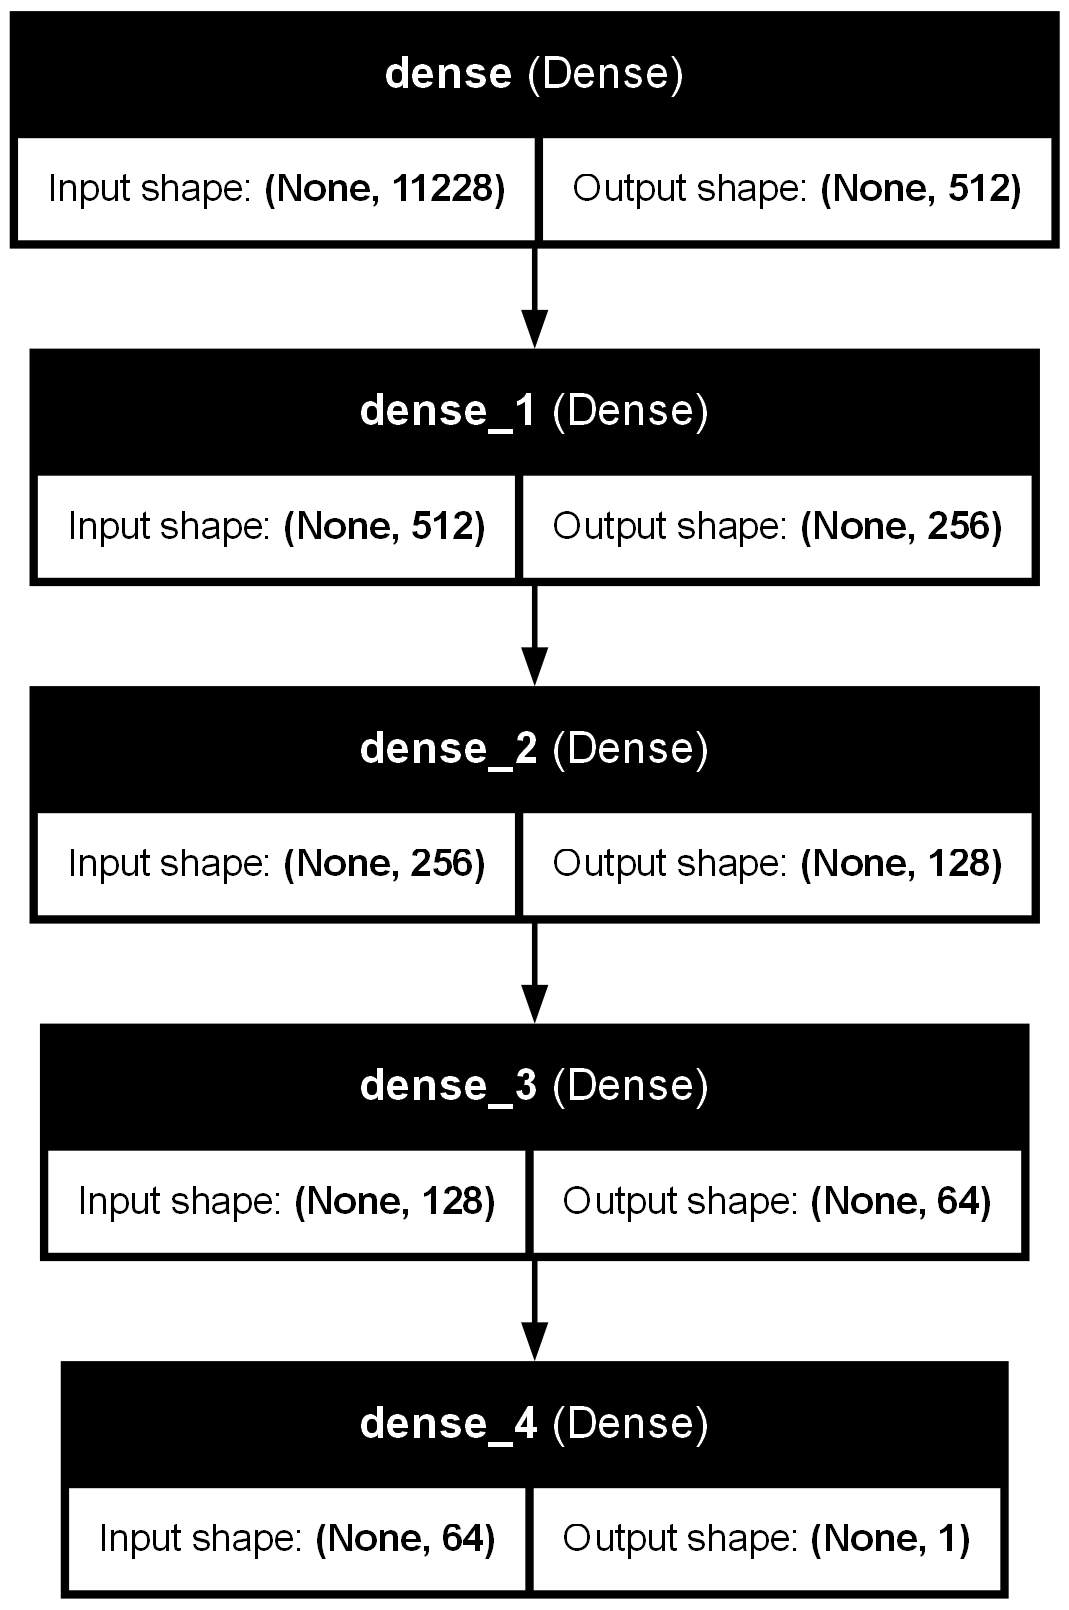

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:

# Define the callback
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)
model.fit(X_train, 
         y_train,
          epochs = 32,
          batch_size=100,
         validation_data=(X_val, y_val)
    #      , callbacks=[early_stop]
         )

Epoch 1/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0564 - mae: 0.2702 - mean_squared_error: 0.1170 - val_loss: 0.0347 - val_mae: 0.2062 - val_mean_squared_error: 0.0709
Epoch 2/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0351 - mae: 0.2064 - mean_squared_error: 0.0721 - val_loss: 0.0338 - val_mae: 0.2189 - val_mean_squared_error: 0.0677
Epoch 3/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0236 - mae: 0.1769 - mean_squared_error: 0.0473 - val_loss: 0.0211 - val_mae: 0.1611 - val_mean_squared_error: 0.0428
Epoch 4/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0220 - mae: 0.1596 - mean_squared_error: 0.0447 - val_loss: 0.0206 - val_mae: 0.1611 - val_mean_squared_error: 0.0414
Epoch 5/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0177 - mae: 0.1479 - mean_squared_error: 0.0355 - val_loss: 0.0225 - val_mae: 0.1687 - val_mean_squared_error: 0.0450
Epoch 6/32
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0173 - mae: 0.1428 - mean_squared_error: 0.0347 - val_l

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


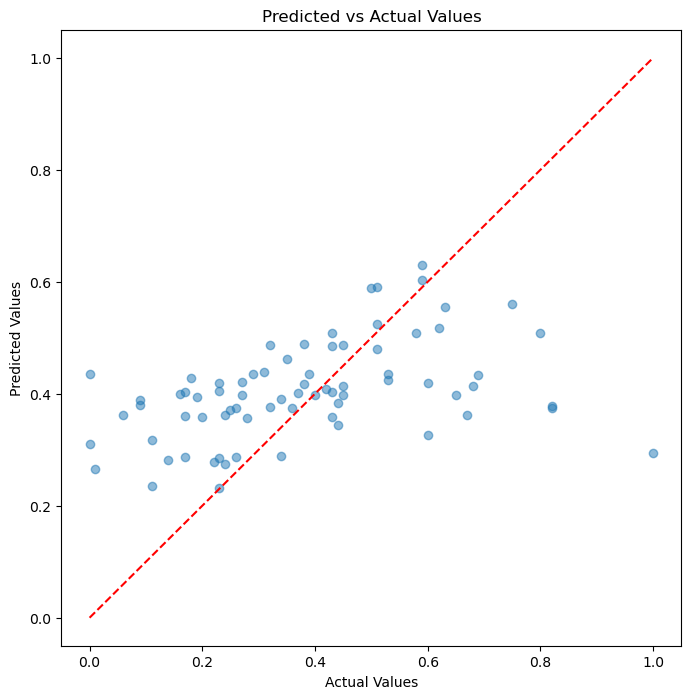

In [19]:
# Generate predictions
y_pred = model.predict(X_val)

# Plot predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--') # Reference line y = x
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


Text(0.5, 1.0, 'Distribution of pct change in real data')

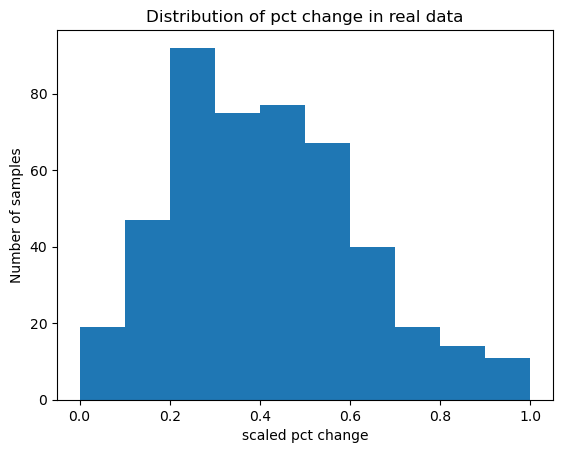

In [20]:
plt.hist(df["scaled_pct_change"])
plt.xlabel('scaled pct change')
plt.ylabel('Number of samples')
plt.title('Distribution of pct change in real data')

Model performance is poor at the extremes, probably due to n. Generate synthetic data at the extremes; 0-0.1, and 0.7-1.0

In [21]:
# function to perform SMOGN-like targeted oversampling with noise to generate synthetic data to fill in the under-represented region
def smogn_like_oversampling(
    data, target_column,
    lower_bound_1, upper_bound_1,
    lower_bound_2, upper_bound_2,
    noise_level=0.001, oversampling_ratio=1.0
):
    """
    Perform SMOGN-like targeted oversampling with noise.

    Parameters:
    - data: DataFrame, input data.
    - target_column: str, name of the target column.
    - lower_bound_1, upper_bound_1: float, bounds of first underrepresented region.
    - lower_bound_2, upper_bound_2: float, bounds of second underrepresented region.
    - noise_level: float, standard deviation of Gaussian noise.
    - oversampling_ratio: float, how much to oversample the underrepresented regions.
What the Oversampling Does
When we oversample the underrepresented regions, we:

Identify rows in the original dataset where the target value is in the rare ranges (e.g., 0.0–0.2 or 0.7–1.0).
Duplicate those rows, meaning we copy both the feature values and the target value.
Add small noise only to the target value, keeping the feature values the same.
So yes, the feature values in the oversampled data are real values from the original dataset that correspond to similar target values. This helps the model learn the patterns in those regions better without introducing unrealistic feature-target combinations.
    Returns:
    - DataFrame with oversampled data.
    """
    # Identify underrepresented regions
    underrepresented_1 = data[(data[target_column] >= lower_bound_1) & (data[target_column] <= upper_bound_1)]
    underrepresented_2 = data[(data[target_column] >= lower_bound_2) & (data[target_column] <= upper_bound_2)]
    
    # Combine underrepresented samples
    underrepresented = pd.concat([underrepresented_1, underrepresented_2])
    
    # Oversample with replacement
    oversampled = underrepresented.sample(frac=oversampling_ratio, replace=True, random_state=123)
    
    # Add Gaussian noise to the target
    oversampled[target_column] += np.random.normal(0, noise_level, size=oversampled.shape[0])
    
    # Clip target values to stay within [0, 1]
    oversampled[target_column] = oversampled[target_column].clip(0, 1)
    
    # Combine with original data
    oversampled_data = pd.concat([data, oversampled], ignore_index=True)
    
    return oversampled_data


In [22]:
#def updated_smogn_like_oversampling(
 #   data, target_column,
 #   lower_bound_1, upper_bound_1,
#    lower_bound_2, upper_bound_2,
#    noise_level=0.01
#):
#    """
#    Perform adaptive SMOGN-like targeted oversampling with noise.
#    """
    # Identify underrepresented regions
#    underrepresented_1 = data[(data[target_column] >= lower_bound_1) & (data[target_column] <= upper_bound_1)]
#    underrepresented_2 = data[(data[target_column] >= lower_bound_2) & (data[target_column] <= upper_bound_2)]
#    underrepresented = pd.concat([underrepresented_1, underrepresented_2])
    
    # Calculate how many samples are needed to balance the dataset
#    total_samples_needed = len(data) - len(underrepresented)
    
    # Oversample underrepresented data
#    oversampled = underrepresented.sample(n=total_samples_needed, replace=True, random_state=123)
    
    # Add Gaussian noise to the target
 #   oversampled[target_column] += np.random.normal(0, noise_level, size=oversampled.shape[0])
#    oversampled[target_column] = oversampled[target_column].clip(0, 1)
    
    # Combine with original data
#    oversampled_data = pd.concat([data, oversampled], ignore_index=True)
    
#    return oversampled_data
# use the function to generate synthetic data for the regions that seem underrepresented
#updated_df2 =  updated_smogn_like_oversampling(
#    df, target_column = "scaled_pct_change",
#    lower_bound_1 = 0.0,
#    upper_bound_1 = 0.1,
#    lower_bound_2 = 0.7, 
#    upper_bound_2 = 1.0,
#    noise_level=0.01)
#updated_df2

What the Oversampling Does
When we oversample the underrepresented regions, we:

Identify rows in the original dataset where the target value is in the rare ranges (e.g., 0.0–0.2 or 0.7–1.0).
Duplicate those rows, meaning we copy both the feature values and the target value.
Add small noise only to the target value, keeping the feature values the same.
So yes, the feature values in the oversampled data are real values from the original dataset that correspond to similar target values. This helps the model learn the patterns in those regions better without introducing unrealistic feature-target combinations.

In [23]:
# use the function to generate synthetic data for the regions that seem underrepresented
updated_df =  smogn_like_oversampling(
    df, target_column = "scaled_pct_change",
    lower_bound_1 = 0.0,
    upper_bound_1 = 0.1,
    lower_bound_2 = 0.7, 
    upper_bound_2 = 1.0,
    noise_level=0.001, oversampling_ratio=4.0)
updated_df

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition,TSPAN6,DPM1,SCYL3,...,ENSG00000308270,ENSG00000309097,ENSG00000309174,ENSG00000309618,ENSG00000310376,CAST,ENSG00000310523,WASH7P,WASH9P,ENSG00000310533
0,FP11w0L,22.3,23.6,0.040000,No_responder,1,RM10,-0.91,0.53,-0.39,...,0.02,-0.73,-1.07,-0.64,3.30,2.08,-0.64,-0.17,-0.74,-1.32
1,FP11w0R,22.3,23.6,0.160000,Average_responder,3,RM10,-0.80,0.47,-0.31,...,-0.07,-0.98,-0.94,-0.80,3.30,2.15,-0.65,-0.19,-0.91,-1.23
2,FP12w0L,21.3,22.8,0.200000,Average_responder,1,RM10,-0.72,0.58,-0.63,...,-0.28,-0.68,-1.11,-0.54,2.86,1.72,-0.53,-0.50,-0.52,-1.14
3,FP12w0R,21.3,22.8,0.110000,No_responder,3,RM10,-0.68,0.46,-0.70,...,-0.22,-0.78,-1.23,-0.25,2.81,1.71,-0.54,-0.00,-0.38,-1.61
4,FP13w0L,22.7,19.8,0.990000,High_responder,3,RM10,-0.70,0.59,-0.81,...,-0.42,-0.81,-1.23,-0.56,2.89,1.73,-0.93,0.06,-0.10,-0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,FP7w0R,21.2,28.2,0.940323,High_responder,1,RM10,-0.83,0.61,-0.67,...,0.30,-0.83,-1.12,-0.52,2.98,1.79,-0.75,-0.23,-0.71,-1.35
729,s632,55.0,33.7,0.769657,High_responder,3,RM10,-1.11,0.14,-0.69,...,-0.57,-1.43,-1.14,-1.53,1.53,1.65,-0.01,0.22,0.07,-1.42
730,FP13w0L,22.7,19.8,0.989926,High_responder,3,RM10,-0.70,0.59,-0.81,...,-0.42,-0.81,-1.23,-0.56,2.89,1.73,-0.93,0.06,-0.10,-0.67
731,X250PreExcVLR538,73.8,22.8,0.849184,High_responder,3,RM30,-0.75,0.58,-0.35,...,-0.50,-1.16,-1.69,-0.55,3.39,1.83,-0.76,-0.58,-0.35,-0.78


Original data shape: (461, 11232)
Oversampled data shape: (733, 11232)


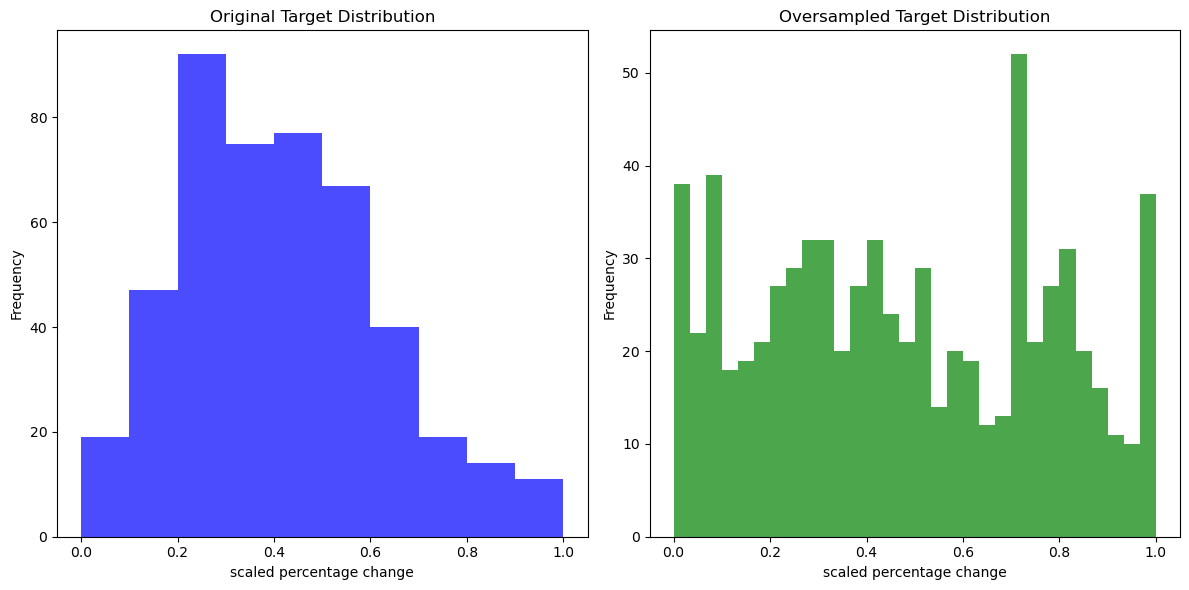

In [24]:

# Display the shape of the original and oversampled datasets
print(f"Original data shape: {df.shape}")
print(f"Oversampled data shape: {updated_df.shape}")

# Plot the distribution of the target variable before and after oversampling
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['scaled_pct_change'], bins=10, color='blue', alpha=0.7)
plt.title('Original Target Distribution')
plt.xlabel('scaled percentage change')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(updated_df['scaled_pct_change'], bins=30, color='green', alpha=0.7)
plt.title('Oversampled Target Distribution')
plt.xlabel('scaled percentage change')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


using same parameters as before train model

In [25]:
# predictor variable
X_new = updated_df.drop(["seq_sample_id", "scaled_pct_change", "category", "condition"],axis = 1)
#X = np.array(X, dtype=np.float32)

# Predicted variable
y_new = updated_df["scaled_pct_change"]
#y = np.array(y, dtype=np.float32)
#split into train and test. Test set will be 20% of the data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=.2,random_state =123)

# from the training set, extract the validation set
X_train_new, X_val_new,  y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, test_size = 0.2, random_state = 123)

# print their shapes

print("Training set:", X_train_new.shape, y_train_new.shape)
print("Validation set:", X_val_new.shape, y_val_new.shape)
print("Testing set:", X_test_new.shape, y_test_new.shape)

Training set: (468, 11228) (468,)
Validation set: (118, 11228) (118,)
Testing set: (147, 11228) (147,)


In [52]:
# Model building
new_model = Sequential( [Input(shape = (11228,)), 
    Dense(4096, activation= "relu"),               
    Dense(2048, activation= "relu"),
    tf.keras.layers.Dropout(0.4),                     
    Dense(1024, activation= "relu"),
    Dense(512, activation= "relu"),
    Dense(256, activation= "relu"),
     Dense(128, activation= "relu"),                    
    Dense(1, activation = "sigmoid"),])

# model compilation
new_model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004),
             loss = tf.keras.losses.Huber(delta = 0.1), # delta 0.1 has balanced sensistivity
             metrics= ["mean_squared_error", "mae"])

In [53]:
new_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 4096)                │      45,993,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 2048)                │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,171,969 (218.09 MB)

 Trainable params: 57,171,969 (218.09 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#tf.keras.utils.plot_model(new_model, show_shapes=True, show_layer_names=True)

In [54]:

# Define the callback
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)
new_model.fit(X_train_new, 
         y_train_new,
          epochs = 50,
          batch_size=100,
         validation_data=(X_val_new, y_val_new)
#        , callbacks=[early_stop]
         )

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - loss: 0.0245 - mae: 0.2913 - mean_squared_error: 0.1275 - val_loss: 0.0146 - val_mae: 0.1908 - val_mean_squared_error: 0.0585
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - loss: 0.0192 - mae: 0.2380 - mean_squared_error: 0.0849 - val_loss: 0.0144 - val_mae: 0.1873 - val_mean_squared_error: 0.0583
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - loss: 0.0193 - mae: 0.2374 - mean_squared_error: 0.0870 - val_loss: 0.0179 - val_mae: 0.2246 - val_mean_squared_error: 0.0792
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - loss: 0.0197 - mae: 0.2423 - mean_squared_error: 0.0933 - val_loss: 0.0144 - val_mae: 0.1894 - val_mean_squared_error: 0.0603
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - loss: 0.0188 - mae: 0.2328 - mean_squared_error: 0.0891 - val_loss: 0.0209 - val_mae: 0.2554 - val_mean_squared_error: 0.0951
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - loss: 0.0200 - mae: 0.2455 - mean_squared_error: 0.0929 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


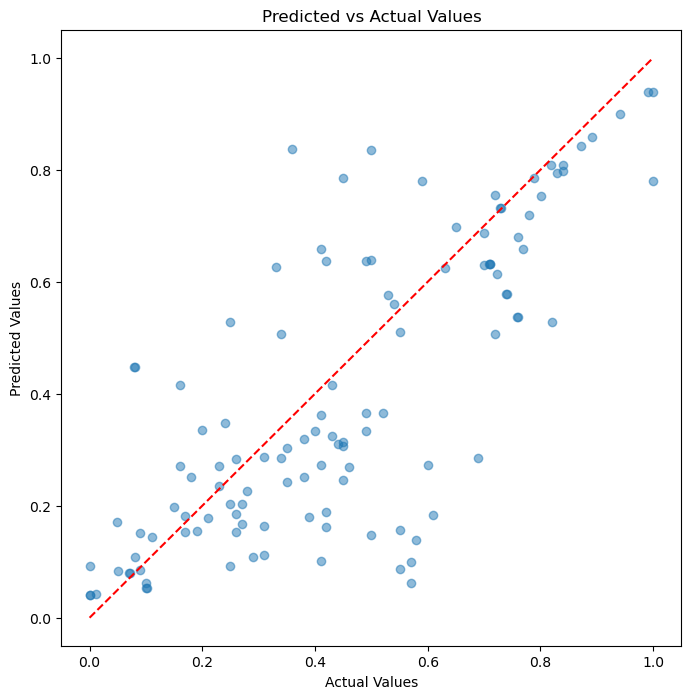

In [55]:
# Generate predictions
y_pred_new = new_model.predict(X_val_new)

# Plot predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_val_new, y_pred_new, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--') # Reference line y = x
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


(array([102.,  55.,  92.,  75.,  77.,  67.,  44.,  97.,  66.,  58.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

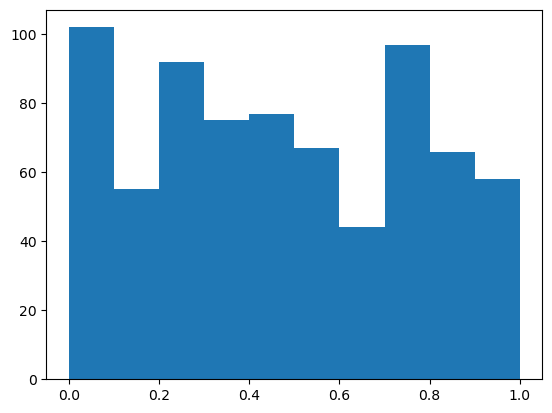

In [22]:
plt.hist(updated_df["scaled_pct_change"])

(array([19., 47., 92., 75., 77., 67., 40., 19., 14., 11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

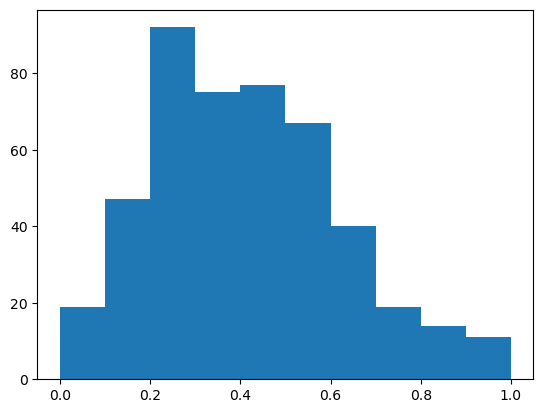

In [111]:
plt.hist(df["scaled_pct_change"])

# Explainability using LIME

In [56]:
explainer = LimeTabularExplainer(X_new.values,
                                 feature_names=X_new.columns,
                                                mode='regression', 
                                 class_names = ["scaled_pct_change"],
                                 random_state = 123)

In [57]:
# get explanation for first row
exp = explainer.explain_instance(X_new.iloc[0],
                                new_model.predict,
                                labels = X_new.columns)
exp.show_in_notebook(show_table=True)

C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\chidimmpe\AppData\Local\anaconda\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

# Extract interpretation for all samples

In [59]:

def return_weights(exp):
    """Extract weights from LIME explanation object for regression"""
    # Get the explanation map
    exp_map = exp.as_map()
    # Handle the case where the key might not be None
    key = list(exp_map.keys())[0] # Get the first and only key
    exp_list = exp_map[key]
    exp_list = sorted(exp_list, key=lambda x: x[0])# Sort by feature index
    exp_weight = [x[1] for x in exp_list] # extract weight
    
    return exp_weight, [x[0] for x in exp_list] # return weight and feature indices

In [ ]:
weights = []
feature_indices = []
#  iterate over first 10 rows
for x in X_new.values[0:11228]:
    #Get explanation
    exp = explainer.explain_instance(x,
                                    new_model.predict,
                                    num_features= 20,
                                   # labels = X.columns
                                    )

    # get weights
    exp_weight, indices = return_weights(exp)
    weights.append(exp_weight)
    feature_indices.append(indices)



# Use the first explanation's feature indices to get column names
first_indices = feature_indices[0]
columns = [X_new.columns[i] for i in first_indices]

# Create dataframe

lime_weights = pd.DataFrame(data=weights, columns=columns)

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


In [ ]:
lime_weights.head()

In [ ]:
# geta absolute mean of LIME weights
abs_mean = lime_weights.abs().mean(axis = 0)
abs_mean = pd.DataFrame(data={"feature" : abs_mean.index, "abs_mean" : abs_mean})
abs_mean = abs_mean.sort_values("abs_mean")

# plot the mean
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y = y_ticks, width = abs_mean.abs_mean,)
plt.yticks(ticks = y_ticks, labels = y_labels, size = 12)
plt.xlabel("Mean |Weight|", size = 15)

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize = (8,3))

# Extract weights and feature values
feature_weight = lime_weights["age"]
feature_values = X_new["age"][0:11228]

plt.scatter(x= feature_values, y= feature_weight)

plt.ylabel("Lime weight", size = 12)
plt.xlabel("age", size = 12)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols= 1, figsize=(8,4))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

# scatterplot for each feature

for i, feature in enumerate(y_labels):
    feature_weight = lime_weights[feature]
    feature_value = X_new[feature][0:11228]

    plt.scatter(x= feature_weight,
               y= [i]*len(feature_weight),
               c= feature_value,
               cmap = "bwr",
               edgecolors = "black",
               alpha = 0.8)

plt.vlines(x=0, ymin = 0, ymax = len(y_labels), colors = "black", linestyles = "--")
plt.colorbar(label= "Feature Value", ticks = [])

plt.yticks(ticks = y_ticks, labels=y_labels, size = 12)
plt.xlabel("Lime Weight", size = 15)

## Explainability using Shap


In [ ]:

# Create background dataset using local RNG
rng = np.random.default_rng(42)
indices = rng.choice(X_train.shape[0], 200, replace=False)
background = X_train.iloc[indices]

# Use SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background.values)
shap_values = explainer.shap_values(X_test.iloc[0:100].values)

plt.figure(figsize=(12, 8))
# Generate summary bar plot
shap.summary_plot(shap_values, X_test.iloc[0:100].values, plot_size= (12, 8),  max_display=30, feature_names = X.columns )

#plt.gcf().set_size_inches(8, 5)
#plt.show()

# Customize font sizes
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.xlabel("SHAP value (impact on model output)", fontsize=16)
#plt.title("SHAP Summary Plot", fontsize=18)

#plt.tight_layout()
#plt.show()



In [193]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655822
[LightGBM] [Info] Number of data points in the train set: 294, number of used features: 10929
[LightGBM] [Info] Start training from score 0.415782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,111342162034991510239313920.00,-13115380543186988867535241216.00,23699470895538.13,2.27
SGDRegressor,3733009266342864355328000.00,-439724145862582838478503936.00,4339486675023.67,1.47
TransformedTargetRegressor,1177080095032920244224.00,-138652358585562578288640.00,77056953163.42,0.62
LinearRegression,1177080095032920244224.00,-138652358585562578288640.00,77056953163.42,0.55
MLPRegressor,1.11,-11.97,0.75,7.43
KernelRidge,1.04,-3.57,0.44,0.52
GaussianProcessRegressor,1.03,-2.58,0.39,3.41
OrthogonalMatchingPursuit,1.01,-0.60,0.26,0.87
ExtraTreeRegressor,1.01,-0.48,0.25,1.28


## Dimensionality reduction using autoencoder

In [49]:
input_layer = Input(shape= (10929,))
encoded = Dense(512, activation= "relu")(input_layer)
encoded = Dense(1280, activation = "relu")(encoded) # 128 is the size we want the compressed data's dimension

decoded = Dense(512, activation="relu")(encoded)
decoded = Dense(10929, activation= "sigmoid")(decoded)


# Autoencoder model

autoencoder = Model(inputs=input_layer, outputs=decoded)


In [50]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss = tf.keras.losses.Huber(delta = 0.5),
             metrics= ["mean_squared_error", "mae"])

In [51]:
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 10929)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │       5,596,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1280)                │         656,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 10929)               │       5,606,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,515,249 (47.74 MB)

 Trainable params: 12,515,249 (47.74 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
autoencoder.fit(X_train, 
         X_train,
          epochs = 30,
          batch_size=64,
         validation_split= 0.2)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.3501 - mae: 0.9244 - mean_squared_error: 1.5566 - val_loss: 0.3400 - val_mae: 0.9026 - val_mean_squared_error: 1.5465
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3341 - mae: 0.8898 - mean_squared_error: 1.4884 - val_loss: 0.3045 - val_mae: 0.8252 - val_mean_squared_error: 1.3951
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2938 - mae: 0.8021 - mean_squared_error: 1.3241 - val_loss: 0.2541 - val_mae: 0.7158 - val_mean_squared_error: 1.1832
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2446 - mae: 0.6950 - mean_squared_error: 1.1073 - val_loss: 0.2166 - val_mae: 0.6344 - val_mean_squared_error: 1.0260
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2112 - mae: 0.6225 - mean_squared_error: 0.9758 - val_loss: 0.1995 - val_mae: 0.5970 - val_mean_squared_error: 0.9552
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1975 - mae: 0.5923 - mean_squared_error: 0.9090 - val_l

In [53]:
encoder = Model(inputs=input_layer, outputs=encoded)
compressed_features = encoder.predict(X)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


## Principal component analyses to reduce data dimension

In [91]:
# predictor variable
#Q = df.drop(["seq_sample_id", "scaled_pct_change", "category", "condition"],axis = 1)


# Predicted variable
#R = df["scaled_pct_change"]


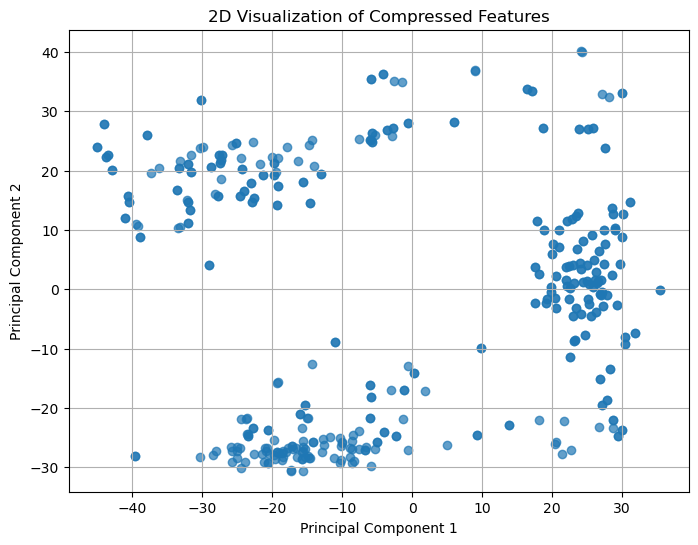

In [92]:
pca = PCA(n_components=0.95) # keep 95% of variance
reduced = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
plt.title("2D Visualization of Compressed Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [93]:
pca_reduced = pd.DataFrame(reduced, columns =[f'PC{i+1}' for i in range(reduced.shape[1])])
pca_reduced["scaled_pct_change"] = y
pca_reduced

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,scaled_pct_change
0,-17.009553,-26.955513,-1.102163,0.368799,-5.497852,1.831922,-6.048456,4.257982,1.382672,2.627725,...,-0.190661,-0.920189,0.844159,-0.546784,-0.497475,0.362383,-0.337828,-0.388939,-0.098863,0.42
1,-15.353356,-26.942293,0.185012,-1.158036,-4.245115,5.660300,-4.050218,5.070303,1.787406,0.628710,...,0.046216,-1.052141,1.869912,-1.238542,-0.317609,0.148157,-0.026470,-0.262625,0.293308,0.33
2,-21.552706,-27.713138,4.058438,-3.256170,0.096390,-4.785376,-1.601513,-5.461312,-2.751303,-1.445772,...,0.436271,0.002461,0.844046,-0.809758,0.190378,1.020939,-0.063765,0.592022,0.071233,0.92
3,-15.819796,-27.496480,5.795441,-3.796850,-1.493833,-4.803340,-1.009635,-6.533948,-0.396712,0.839036,...,0.184521,0.223610,1.054939,-0.595867,0.233978,0.819716,-0.183320,0.805415,0.220296,0.26
4,-10.288205,-29.356797,11.681490,-4.323152,8.130007,6.065460,-8.691654,-1.140684,-5.287556,1.994333,...,-0.572495,-0.538535,-1.767588,-0.818825,-0.071451,-1.383901,0.591652,1.133275,0.542815,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,24.335984,8.066202,3.777806,-7.158326,-1.440083,-3.531420,-2.353882,-4.026289,-1.480920,-2.432147,...,-1.671153,0.104609,0.728539,-0.960421,0.386182,0.241347,0.058755,0.369574,-1.089264,0.09
457,24.098635,-4.157770,-0.301224,-0.024118,-0.124915,-4.992784,1.344683,-0.830112,-4.298889,-2.820484,...,0.862879,-0.186988,-0.504917,-1.607047,-0.697918,-0.032893,-0.480830,0.892437,-0.232744,0.73
458,24.098635,-4.157770,-0.301224,-0.024118,-0.124915,-4.992784,1.344683,-0.830112,-4.298889,-2.820484,...,0.862879,-0.186988,-0.504917,-1.607047,-0.697918,-0.032893,-0.480830,0.892437,-0.232744,0.94
459,24.384951,1.208084,0.651528,-0.434656,3.421796,-1.957035,-2.008732,6.459387,-1.330097,3.367509,...,-0.298588,-1.998757,0.479009,-0.639858,0.626854,-1.150981,-0.531257,0.782230,-0.983327,0.65


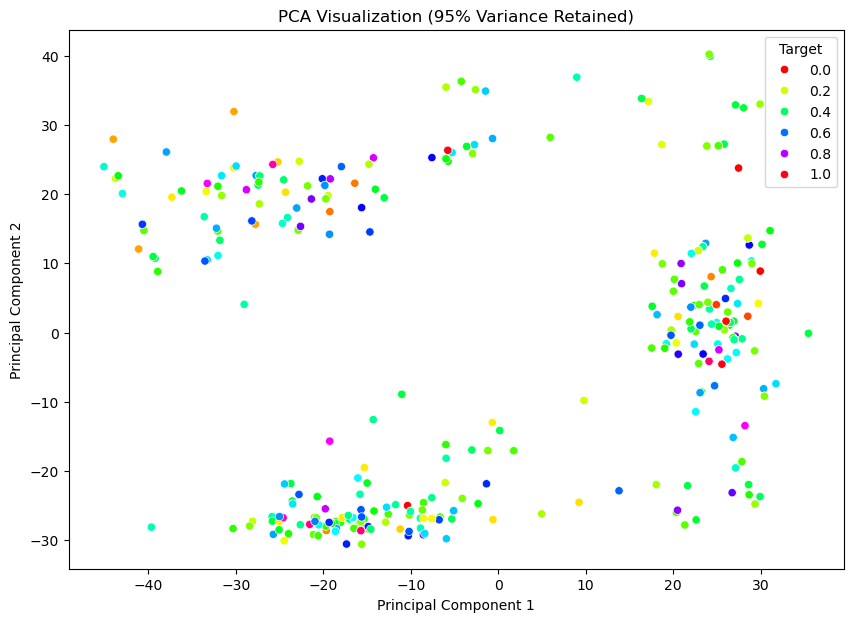

In [94]:

# Step 6: Visualize the first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='scaled_pct_change', palette='hsv', data=pca_reduced)
plt.title('PCA Visualization (95% Variance Retained)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Target')
plt.show()


In [96]:

# Get the loadings (contributions of original features to each PC)
loadings = pd.DataFrame(pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=Q.columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122
age,-0.050129,0.964717,0.120903,0.015171,0.062403,0.000751,-0.029188,0.058774,-0.012726,0.050265,...,-0.007458,0.004140,0.001257,-0.010423,0.002947,-0.008660,-0.002540,-0.004820,-0.000182,0.000722
BMI,0.067902,0.013690,-0.031331,0.830945,0.119326,0.074277,0.299830,0.091041,0.013335,0.067471,...,0.012940,-0.007855,0.004931,0.011902,-0.014087,0.012877,0.009774,0.002112,-0.007776,0.011266
volume,0.002982,0.010600,0.015792,0.030208,0.009767,-0.009030,0.011955,-0.020202,-0.005784,-0.042595,...,-0.063165,-0.030768,0.004365,0.047943,-0.008079,-0.061718,0.029248,0.058458,0.000612,-0.033068
ENSG00000000003.16,-0.004263,-0.002014,-0.004791,-0.005714,0.007216,0.001622,0.006149,0.003698,-0.003895,-0.002396,...,0.001114,0.006296,-0.022292,-0.019975,0.012014,-0.008929,0.001477,-0.005940,0.007916,-0.005268
ENSG00000000419.14,-0.008139,-0.001859,0.007411,0.001244,0.011935,0.000540,-0.002468,-0.003021,-0.001546,0.008679,...,0.003066,-0.004933,0.004561,0.013359,-0.004579,0.004480,0.006246,-0.004218,0.002130,-0.003171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000310517.1,-0.004488,-0.000449,-0.011975,-0.003728,0.002270,0.010460,-0.005179,0.002669,0.016462,0.009753,...,-0.002367,-0.003214,0.004165,-0.002016,-0.005818,0.000870,0.003296,0.000481,-0.002417,0.004812
ENSG00000310523.1,0.014969,0.003623,0.003483,-0.003826,-0.008769,0.001259,-0.003984,-0.005837,-0.004801,-0.008876,...,0.000736,0.002484,-0.003476,-0.004323,-0.004170,-0.004508,0.004151,0.003358,0.005149,0.003233
ENSG00000310526.1,0.016359,0.000814,0.005875,0.000460,-0.002477,0.001826,-0.003081,-0.011095,-0.000971,0.001992,...,-0.009196,0.005038,-0.007326,-0.007839,-0.026170,0.016313,0.006486,-0.010249,-0.009897,0.003351
ENSG00000310527.1,0.018280,0.001090,0.009078,0.001407,-0.001048,0.002350,-0.003119,-0.009906,-0.003413,-0.000848,...,-0.005824,-0.000999,-0.038967,-0.018169,-0.025603,0.019576,-0.026131,0.000422,0.001560,0.003958


Reduce to 2D using t-SNE

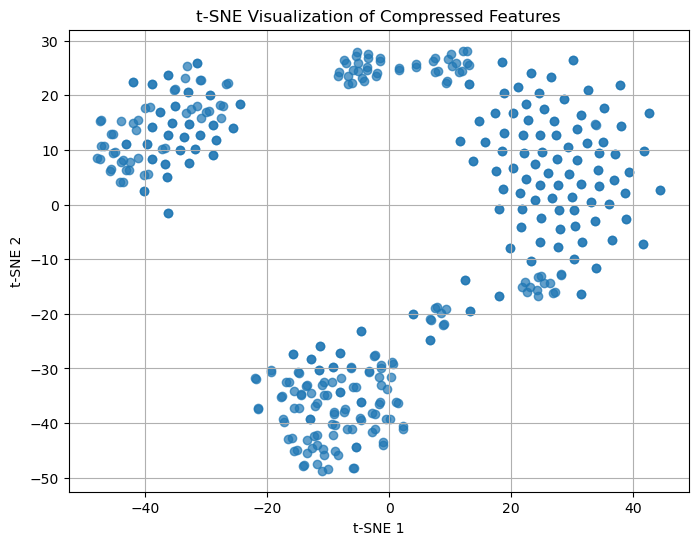

In [64]:
tsne = TSNE(n_components=2, perplexity=30, random_state=123)
reduced_tsne = tsne.fit_transform(reduced)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], alpha=0.7)
plt.title("t-SNE Visualization of Compressed Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

In [67]:
tsne_from_reduced = pd.DataFrame(reduced_tsne, columns = ["TSNE1", "TSNE2"])
tsne_from_reduced["target"] = y
tsne_from_reduced

,TSNE1,TSNE2,target
0,-9.114462,-38.326721,0.04
1,-9.005971,-37.964729,0.16
2,-5.963078,-48.301907,0.20
3,-5.695563,-48.221401,0.11
4,-8.331006,-45.788815,0.99
...,...,...,...
456,20.268131,16.743498,0.47
457,26.712139,1.223836,0.82
458,26.712137,1.223836,0.25
459,27.541100,8.270517,0.32
